 # Importa bibliotecas

In [1]:
import pandas as pd
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Masking, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import datetime
import pickle
import os
import random
import tensorflow as tf


2025-09-15 10:31:15.475353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757943075.502625   32347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757943075.508416   32347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757943075.521016   32347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757943075.521036   32347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757943075.521037   32347 computation_placer.cc:177] computation placer alr

 ## Definições

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


 # Funções

In [3]:
def save_history(history, timestamp):
    with open(f'training_history/pkl/{timestamp}.pkl', 'wb') as f:
        pickle.dump(history.history, f)


 # Preparando dados

In [4]:
csv_files = glob.glob('/mnt/d/dados_surdos/CSVs/dados_pessoa2_*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df


,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,repetition,frame,word
0,-0.015607,-0.012011,0.085424,0.002198,0.002056,0.062723,0.006184,0.013907,0.043209,0.012581,...,0.010308,-0.014324,0.022577,0.024143,-0.012121,0.028077,0.045234,0,0,amanda
1,-0.026881,-0.016575,0.088360,-0.004162,0.000434,0.064802,-0.002506,0.012053,0.047482,0.012059,...,0.006520,-0.015839,0.031193,0.016019,-0.011932,0.045492,0.040148,0,1,amanda
2,-0.035663,-0.030682,0.055793,-0.007602,-0.020255,0.040326,0.010573,-0.015109,0.029176,0.034369,...,0.005534,-0.019610,0.026664,0.005605,-0.010181,0.035500,0.006776,0,2,amanda
3,-0.019877,-0.012865,0.072611,-0.000591,-0.004493,0.054639,0.013915,0.000713,0.042367,0.027604,...,-0.000779,-0.025155,0.012071,-0.001725,-0.019246,0.009204,0.004844,0,3,amanda
4,-0.017428,0.004787,0.097933,0.009870,0.017381,0.064847,0.028842,0.017987,0.040486,0.040202,...,0.009571,-0.020957,0.031525,0.010485,-0.019979,0.045894,0.023430,0,4,amanda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.006988,0.059106,0.065497,0.018958,0.042008,0.045603,0.036582,0.031468,0.027750,0.041668,...,0.002797,-0.024219,-0.000852,0.008091,-0.022274,0.007363,0.013810,9,147,zimbabwe
32557,-0.009849,0.055787,0.067987,0.014397,0.041232,0.047113,0.037282,0.032145,0.029211,0.048260,...,-0.007995,-0.022478,0.014994,-0.003822,-0.018179,0.023010,0.001642,9,148,zimbabwe
32558,-0.010559,0.020268,0.080483,0.017107,0.022272,0.055852,0.036796,0.022708,0.033825,0.051180,...,0.001762,-0.009830,0.034790,0.009860,-0.008334,0.042102,0.022468,9,149,zimbabwe
32559,-0.009250,-0.018638,0.095681,0.017051,-0.004999,0.066634,0.035379,0.004927,0.049955,0.049636,...,0.011627,-0.027174,0.028498,0.016777,-0.027771,0.039360,0.024744,9,150,zimbabwe


In [5]:
# Normaliza features com valores entre 0 e 1
scaler = MinMaxScaler()
landmark_cols = list(df.columns[:63])
df[landmark_cols] = scaler.fit_transform(df[landmark_cols])


In [6]:
# Separa features e labels por vídeo
grouped = df.groupby(['word', 'repetition'])
X_raw = []
y_raw = []

for (word, rep), group in grouped:
    sequence = group[landmark_cols].values
    X_raw.append(sequence)
    y_raw.append(word)


 # KFold Cross Validation

In [7]:
max_len = max(len(seq) for seq in X_raw)
N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
all_fold_accuracies = []
all_fold_losses = []
histories = []

for fold, (train_index, val_index) in enumerate(kf.split(X_raw), 1):
    print(f"\n========== FOLD {fold} ==========")

    X_train_raw = [X_raw[i] for i in train_index]
    y_train_raw = [y_raw[i] for i in train_index]
    X_val_raw   = [X_raw[i] for i in val_index]
    y_val_raw   = [y_raw[i] for i in val_index]

    X_train = pad_sequences(X_train_raw, maxlen=max_len, padding='post', dtype='float32')
    X_val   = pad_sequences(X_val_raw,   maxlen=max_len, padding='post', dtype='float32')

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)

    num_classes = len(label_encoder.classes_)

    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_len, 63)))
    model.add(LSTM(1024))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    checkpoint_filepath = f'models/fold_{fold}_checkpoint.model.keras'

    early_stop = EarlyStopping(patience=30, restore_best_weights=True)
    csv_logger = CSVLogger(f'training_log_fold_{fold}.csv')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001, verbose=1)
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=10,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[csv_logger, reduce_lr, model_checkpoint_callback]
    )

    histories.append(history)

    best_model = load_model(checkpoint_filepath)
    val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
    print(f"FOLD {fold} - Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

    all_fold_accuracies.append(val_accuracy)
    all_fold_losses.append(val_loss)



========== FOLD 1 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-09-15 10:31:20.399045: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


2025-09-15 10:31:21.452234: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0323 - loss: 3.3996

2025-09-15 10:31:52.852119: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0332 - loss: 3.3917 - val_accuracy: 0.0769 - val_loss: 2.9955 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0986 - loss: 3.2179 - val_accuracy: 0.0769 - val_loss: 3.1674 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1088 - loss: 2.9129 - val_accuracy: 0.0769 - val_loss: 2.6168 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1771 - loss: 2.4979 - val_accuracy: 0.2308 - val_loss: 2.3875 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2899 - loss: 2.2909 - val_accuracy: 0.0385 - val_loss: 2.7878 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2005 - loss: 2.5252 - val_accuracy: 0.1923 - val_loss: 2.0774 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3133 - loss: 1.9254 - val_accuracy: 0.4231 - va

2025-09-15 10:36:41.017476: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 1 - Accuracy: 0.4231, Loss: 1.8569

========== FOLD 2 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0396 - loss: 3.4155

2025-09-15 10:37:13.830769: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.0416 - loss: 3.4059 - val_accuracy: 0.0769 - val_loss: 2.8992 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1014 - loss: 2.9117 - val_accuracy: 0.1154 - val_loss: 2.7068 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0995 - loss: 3.2209 - val_accuracy: 0.1538 - val_loss: 2.6197 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1871 - loss: 2.5050 - val_accuracy: 0.1923 - val_loss: 2.2180 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2474 - loss: 2.0753 - val_accuracy: 0.3462 - val_loss: 1.9789 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2512 - loss: 2.2130 - val_accuracy: 0.1538 - val_loss: 2.4737 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2013 - loss: 2.5710 - val_accuracy: 0.3077 - va

2025-09-15 10:41:55.965591: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 2 - Accuracy: 0.4615, Loss: 1.7922

========== FOLD 3 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0693 - loss: 3.4337

2025-09-15 10:42:29.253968: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0700 - loss: 3.4240 - val_accuracy: 0.0385 - val_loss: 3.0315 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0761 - loss: 2.8779 - val_accuracy: 0.2308 - val_loss: 2.6452 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1005 - loss: 3.0806 - val_accuracy: 0.0385 - val_loss: 2.9619 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0921 - loss: 2.9432 - val_accuracy: 0.0385 - val_loss: 2.7786 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2796 - loss: 2.2744 - val_accuracy: 0.0769 - val_loss: 2.2821 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2027 - loss: 1.9883 - val_accuracy: 0.5769 - val_loss: 1.6584 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3842 - loss: 1.6713 - val_accuracy: 0.5000 - va

2025-09-15 10:47:04.444755: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 3 - Accuracy: 0.7308, Loss: 0.9240

========== FOLD 4 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0449 - loss: 3.4175

2025-09-15 10:47:37.632767: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0458 - loss: 3.4106 - val_accuracy: 0.0385 - val_loss: 3.3956 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0873 - loss: 3.0294 - val_accuracy: 0.1923 - val_loss: 2.8441 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1252 - loss: 2.9513 - val_accuracy: 0.1923 - val_loss: 2.6148 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1606 - loss: 2.5575 - val_accuracy: 0.0385 - val_loss: 2.6549 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0928 - loss: 2.7336 - val_accuracy: 0.2692 - val_loss: 2.1019 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2732 - loss: 2.1783 - val_accuracy: 0.0385 - val_loss: 2.1498 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2957 - loss: 2.0428 - val_accuracy: 0.4615 - va

2025-09-15 10:52:14.069874: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 4 - Accuracy: 0.5000, Loss: 1.3676

========== FOLD 5 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0703 - loss: 3.4360

2025-09-15 10:52:46.690979: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.0705 - loss: 3.4289 - val_accuracy: 0.0769 - val_loss: 3.0903 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0939 - loss: 2.9386 - val_accuracy: 0.0385 - val_loss: 2.6224 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1174 - loss: 3.0824 - val_accuracy: 0.0000e+00 - val_loss: 3.0667 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1182 - loss: 2.7259 - val_accuracy: 0.1923 - val_loss: 2.2978 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3398 - loss: 2.2308 - val_accuracy: 0.0385 - val_loss: 3.2404 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0901 - loss: 3.0657 - val_accuracy: 0.0769 - val_loss: 2.4074 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2787 - loss: 2.2866 - val_accuracy: 0.3462 

2025-09-15 10:57:18.821133: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 5 - Accuracy: 0.3462, Loss: 2.0580

========== FOLD 6 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0162 - loss: 3.4004

2025-09-15 10:57:50.265692: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0181 - loss: 3.3925 - val_accuracy: 0.1154 - val_loss: 3.2085 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1272 - loss: 3.0266 - val_accuracy: 0.0769 - val_loss: 2.7966 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1112 - loss: 2.7520 - val_accuracy: 0.1154 - val_loss: 3.1230 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1638 - loss: 2.8094 - val_accuracy: 0.0385 - val_loss: 2.6368 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1748 - loss: 2.2691 - val_accuracy: 0.0385 - val_loss: 2.4593 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2269 - loss: 2.2136 - val_accuracy: 0.2692 - val_loss: 2.3246 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2945 - loss: 2.0998 - val_accuracy: 0.1538 - va

2025-09-15 11:02:12.556602: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 6 - Accuracy: 0.4231, Loss: 1.4441

========== FOLD 7 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0747 - loss: 3.4319

2025-09-15 11:02:44.025598: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0743 - loss: 3.4249 - val_accuracy: 0.1154 - val_loss: 2.8314 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1166 - loss: 2.9962 - val_accuracy: 0.0769 - val_loss: 2.7761 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1424 - loss: 2.6269 - val_accuracy: 0.1154 - val_loss: 2.4132 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2364 - loss: 2.2844 - val_accuracy: 0.3077 - val_loss: 2.0388 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2382 - loss: 2.3917 - val_accuracy: 0.3462 - val_loss: 1.7217 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2996 - loss: 2.2361 - val_accuracy: 0.2308 - val_loss: 2.5257 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1905 - loss: 2.4537 - val_accuracy: 0.1923 - va

2025-09-15 11:07:06.180876: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 7 - Accuracy: 0.3462, Loss: 1.7217

========== FOLD 8 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0480 - loss: 3.4513

2025-09-15 11:07:37.725550: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0495 - loss: 3.4409 - val_accuracy: 0.0385 - val_loss: 3.1860 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.0782 - loss: 2.9421 - val_accuracy: 0.1154 - val_loss: 2.8861 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1140 - loss: 2.7792 - val_accuracy: 0.1538 - val_loss: 2.5461 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1939 - loss: 2.3146 - val_accuracy: 0.3846 - val_loss: 1.9276 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3000 - loss: 2.0207 - val_accuracy: 0.2692 - val_loss: 2.3682 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3290 - loss: 2.1108 - val_accuracy: 0.2692 - val_loss: 1.9640 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2750 - loss: 2.0162 - val_accuracy: 0.3077 - va

2025-09-15 11:12:00.414465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 8 - Accuracy: 0.4615, Loss: 1.3701

========== FOLD 9 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0741 - loss: 3.4971

2025-09-15 11:12:31.677863: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0743 - loss: 3.4874 - val_accuracy: 0.1154 - val_loss: 3.0145 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.0765 - loss: 3.0601 - val_accuracy: 0.1154 - val_loss: 2.8123 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1270 - loss: 2.7904 - val_accuracy: 0.1538 - val_loss: 2.5771 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1496 - loss: 2.4289 - val_accuracy: 0.1923 - val_loss: 2.2550 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3115 - loss: 2.0068 - val_accuracy: 0.3077 - val_loss: 1.8464 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2943 - loss: 2.0232 - val_accuracy: 0.2308 - val_loss: 2.0110 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4042 - loss: 1.7487 - val_accuracy: 0.3077 - va

2025-09-15 11:16:54.806630: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 9 - Accuracy: 0.3846, Loss: 1.5144

========== FOLD 10 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0325 - loss: 3.4182

2025-09-15 11:17:26.034559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0344 - loss: 3.4089 - val_accuracy: 0.0385 - val_loss: 2.8343 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1039 - loss: 2.8378 - val_accuracy: 0.1154 - val_loss: 2.9038 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1394 - loss: 2.9356 - val_accuracy: 0.0385 - val_loss: 2.9901 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2182 - loss: 2.6696 - val_accuracy: 0.1538 - val_loss: 2.5072 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2211 - loss: 2.4333 - val_accuracy: 0.2308 - val_loss: 1.9745 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2918 - loss: 2.2185 - val_accuracy: 0.1538 - val_loss: 2.4958 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3461 - loss: 2.1210 - val_accuracy: 0.2692 - va

2025-09-15 11:21:48.313971: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 10 - Accuracy: 0.5000, Loss: 1.6379


In [8]:
print("\n========== RESULTADOS FINAIS ==========")
for i, (acc, loss) in enumerate(zip(all_fold_accuracies, all_fold_losses), 1):
    print(f"Fold {i}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")
print(f"Média de acurácia: {np.mean(all_fold_accuracies):.4f}")


========== RESULTADOS FINAIS ==========
Fold 1: Accuracy = 0.4231, Loss = 1.8569
Fold 2: Accuracy = 0.4615, Loss = 1.7922
Fold 3: Accuracy = 0.7308, Loss = 0.9240
Fold 4: Accuracy = 0.5000, Loss = 1.3676
Fold 5: Accuracy = 0.3462, Loss = 2.0580
Fold 6: Accuracy = 0.4231, Loss = 1.4441
Fold 7: Accuracy = 0.3462, Loss = 1.7217
Fold 8: Accuracy = 0.4615, Loss = 1.3701
Fold 9: Accuracy = 0.3846, Loss = 1.5144
Fold 10: Accuracy = 0.5000, Loss = 1.6379
Média de acurácia: 0.4577


 # Gráficos de Acurácia e Loss por Fold

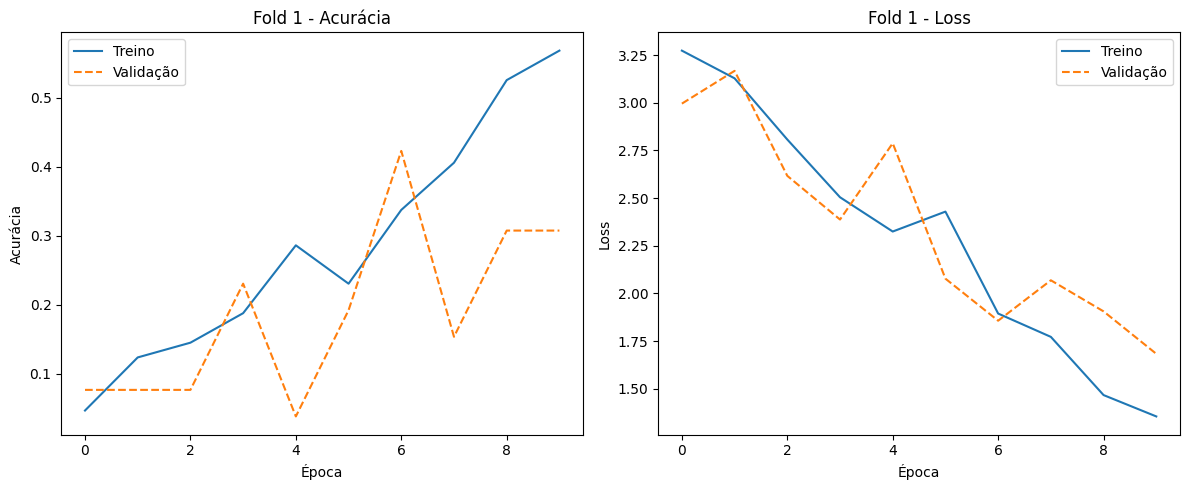

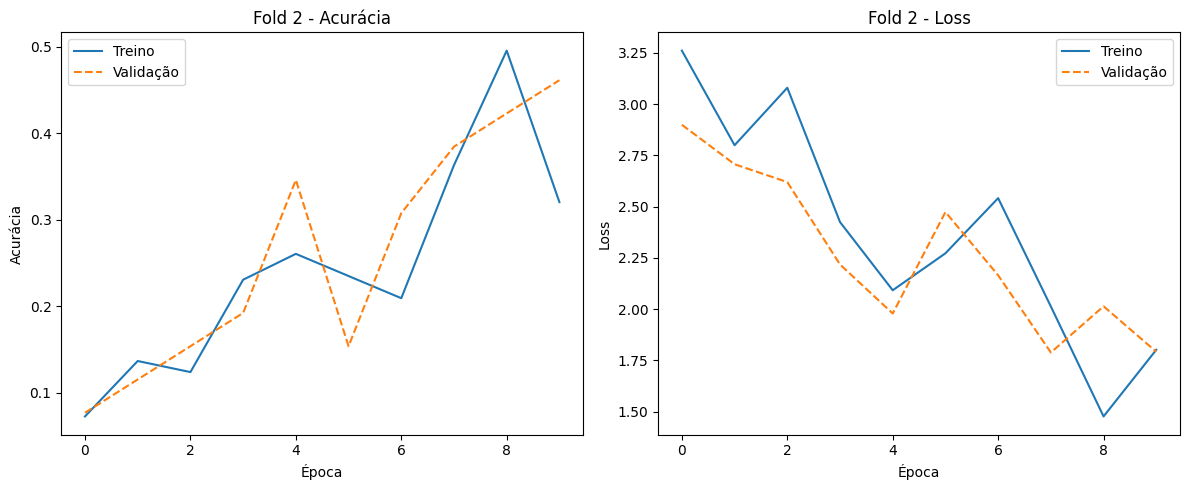

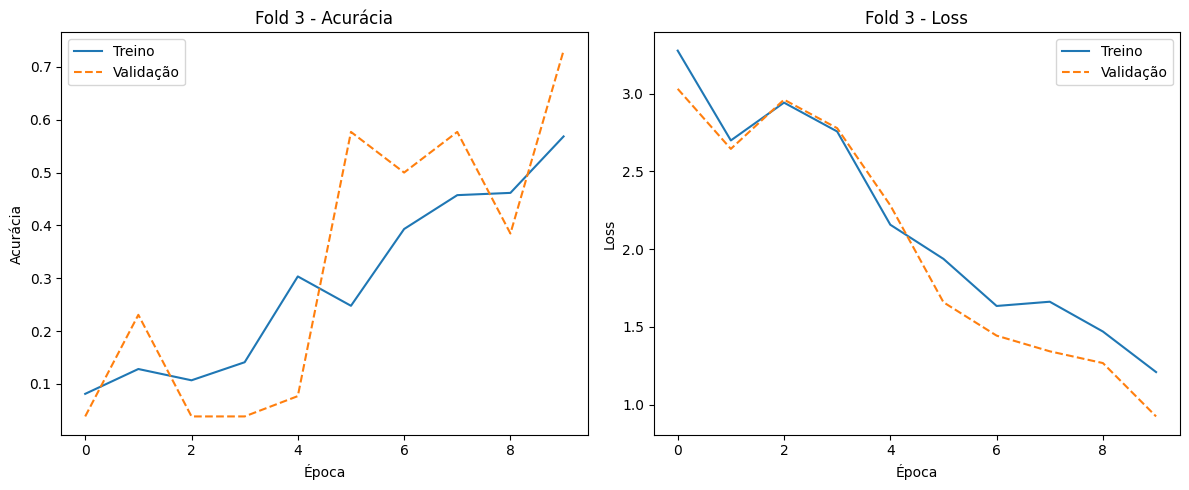

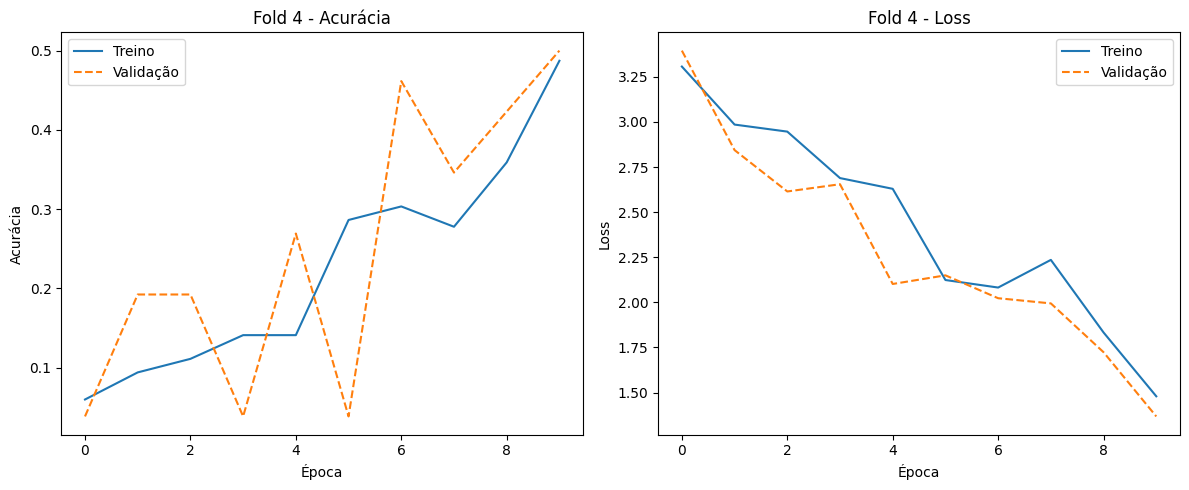

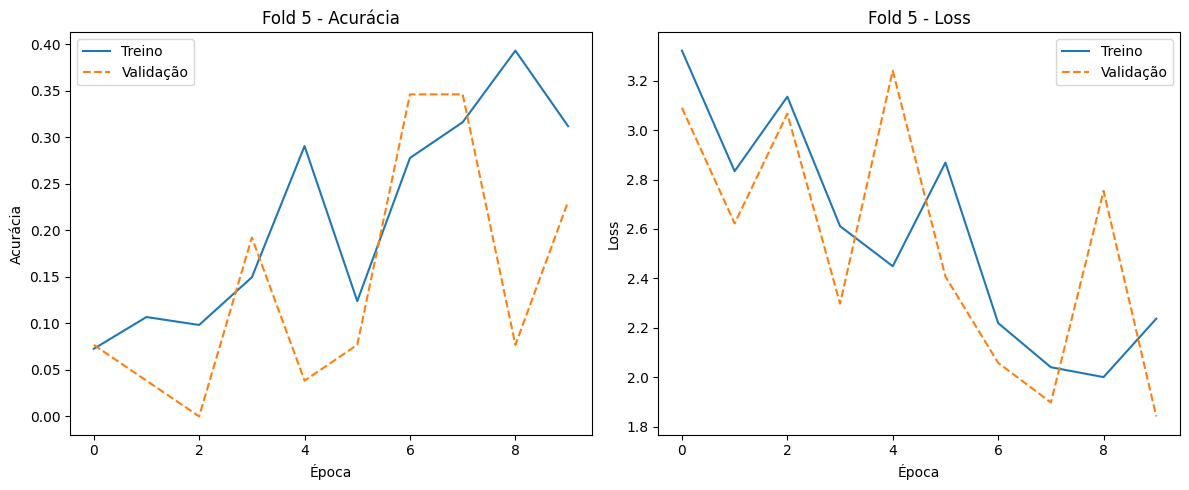

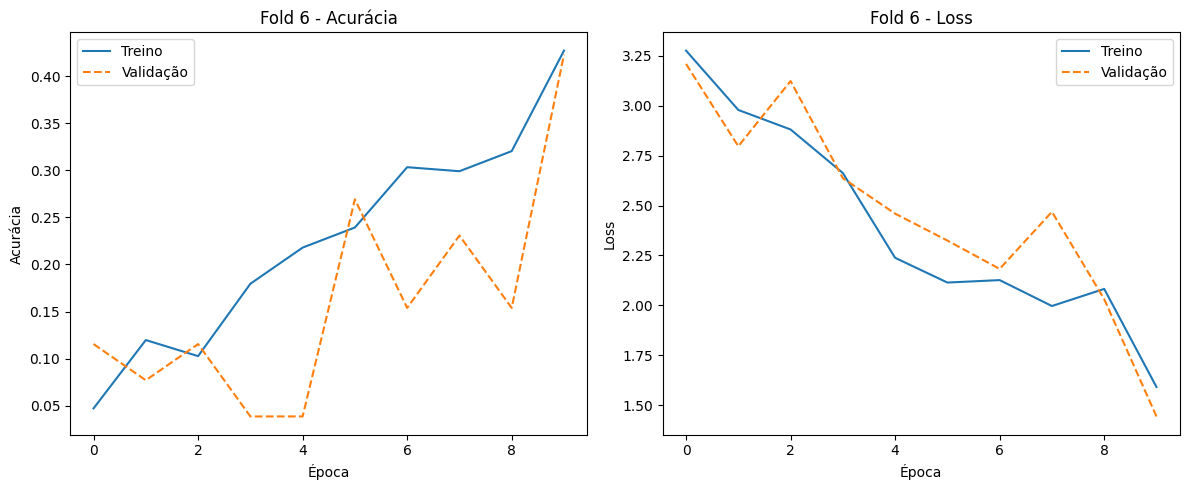

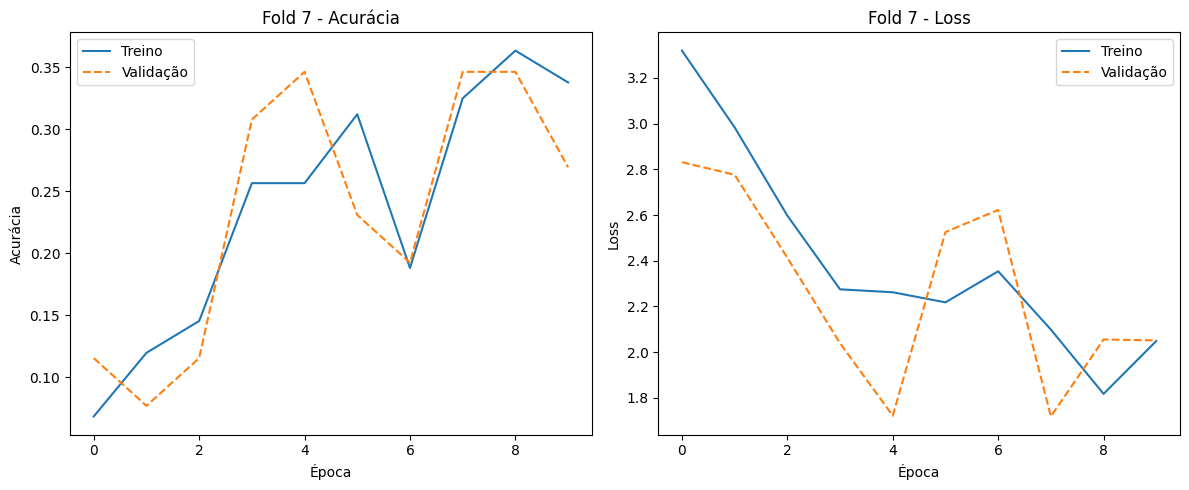

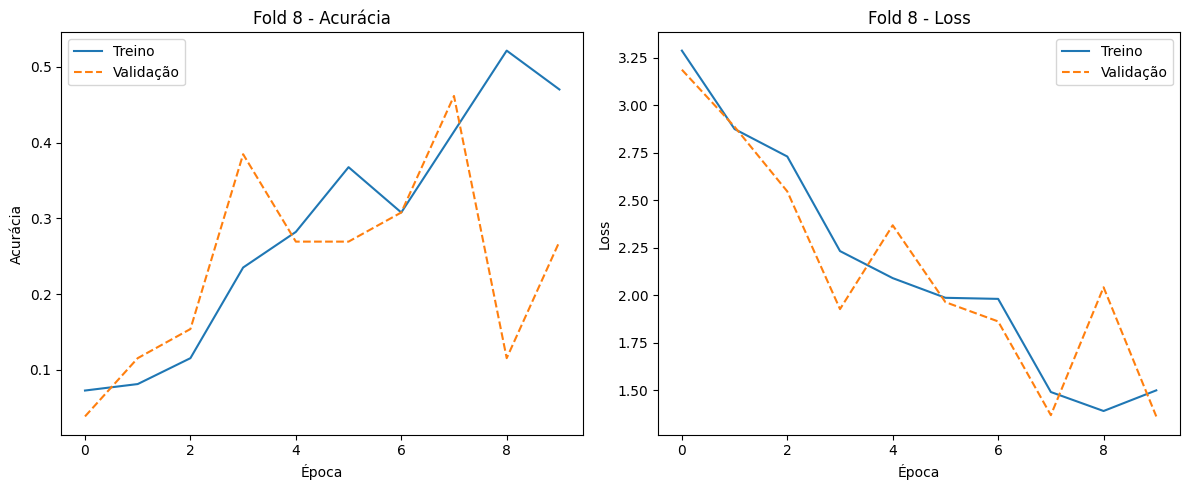

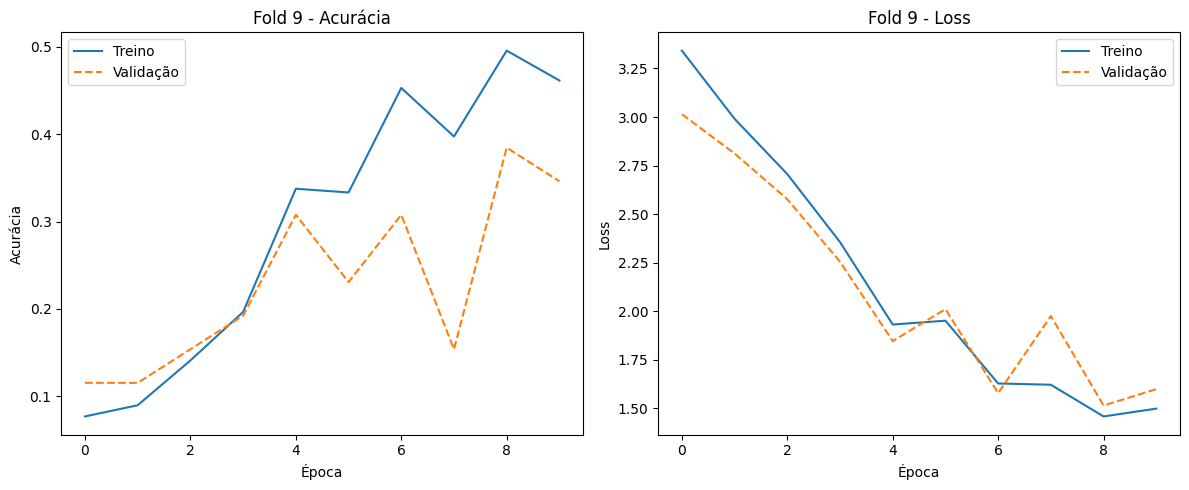

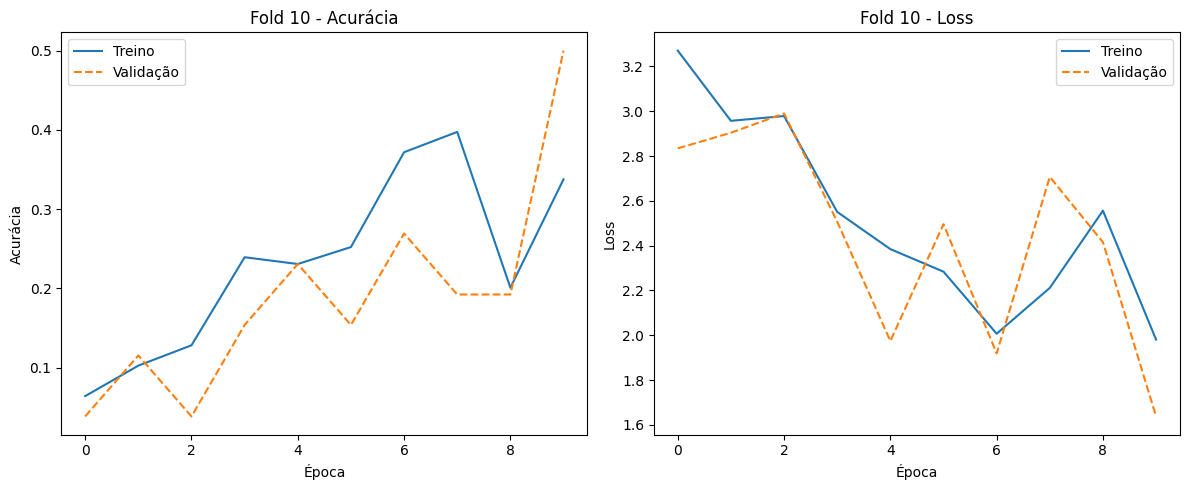

In [9]:
for i, history in enumerate(histories, 1):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

